# Constructing similarity matrices
This notebook provides example code for constructing the similarity matrices used in Xiang et al. 2025 ("Evaluating Interdisciplinary Research"). Note that it uses OpenAlex Concepts, which as of 2025 are being deprecated in favor of Topics.

In [ ]:
import numpy as np  # numpy==2.2.1
import pandas as pd  # pandas==2.2.3
from pyalex import Works, config  # pyalex==0.18
from tqdm import tqdm  # tqdm==4.67.1
import scipy.spatial.distance  # scipy==1.15.3
import matplotlib.pyplot as plt  # matplotlib==3.10.0

config.email = "" # YOUR EMAIL HERE (to get into the OpenAlex polite pool)

## Sampling works by year
In the original work we sampled Crossref then matched the sample to OpenAlex via DOIs. Sampling with PyAlex turns out to be much easier.

In [ ]:
YEAR = 2018
N_SAMP = 10000
sample = []
pager = Works().filter(publication_year=YEAR, type="article").sample(N_SAMP, seed=100).paginate(method="page", per_page=200)
for page in tqdm(pager):
    sample.extend(page)

50it [01:29,  1.79s/it]


## Constructing similarity matrix

In [43]:
# Grab the spreadsheet of OpenAlex concepts here: https://docs.google.com/spreadsheets/d/1LBFHjPt4rj_9r0t0TTAlT68NwOtNH8Z21lBMsJDMoZg/edit?gid=575855905#gid=575855905
# and save it as a CSV
concepts_all = pd.read_csv('OpenAlex concepts in use (17 August 2022) - concepts.csv')

LEVEL = 0  # OpenAlex concept level
concepts = concepts_all[concepts_all["level"] == LEVEL]
concepts.reset_index(drop=True, inplace=True)
num_concepts = len(concepts)
concept_dict = {concepts["openalex_id"][i]: int(i) for i in concepts.index} # used in creation of paper_concept_matrix
concept_names_dict = {int(i): concepts["display_name"][i] for i in concepts.index} # used to rename final sim_df rows and columns for interpretability

In [14]:
def build_pcm(sample, use_score):
    '''
    Building the paper-concept-matrix from a sample.
    
    Input:
        - sample: Sample of papers
        - use_score: Boolean. If True, populates pcm with concept scores. If False, populates with 1/0
    Output:
        - paper_concept_matrix: (#samples x #concepts) numpy matrix containing concept scores for each paper in the sample
    '''
    
    sample_size = len(sample)
    num_concepts = len(concept_dict)
    paper_concept_matrix = np.zeros((sample_size, num_concepts))
    for index, work in enumerate(sample):
        for concept in work['concepts']:
            if concept['level'] == LEVEL:
                if use_score:
                    paper_concept_matrix[index, concept_dict[concept['id'].lower()]] = float(concept['score'])
                else:
                    paper_concept_matrix[index, concept_dict[concept['id'].lower()]] = 1
    return paper_concept_matrix


def build_sim_matrix(pcm):
    '''
    Building the similarity matrix from a paper-concept-matrix
    
    Input:
        - pcm: paper-concept-matrix output by build_pcm
    Output:
        - sim_matrix: (#concepts x #concepts) numpy matrix containing similarity scores between concepts
    '''
    
    num_concepts = pcm.shape[1]
    sim_matrix = np.zeros((num_concepts,num_concepts))
    for i in range(num_concepts):
        for j in range(i+1):
            sim_matrix[i,j] = 1 - scipy.spatial.distance.cosine(pcm[:,i], pcm[:,j])
            sim_matrix[j,i] = sim_matrix[i,j]
    return sim_matrix

In [31]:
pcm = build_pcm(sample, True)
sim_matrix = build_sim_matrix(pcm)

In [47]:
sim_df = pd.DataFrame(sim_matrix).rename(index=concept_names_dict, columns=concept_names_dict)
sim_df

,Political science,Philosophy,Economics,Business,Psychology,Mathematics,Medicine,Biology,Computer science,Geology,Chemistry,Art,Sociology,Engineering,Geography,History,Materials science,Physics,Environmental science
Political science,1.000000,0.213918,0.161056,0.175567,0.101588,0.011271,0.027140,0.004769,0.062091,0.004199,0.002027,0.159789,0.358420,0.057938,0.124109,0.145168,0.001495,0.018113,0.007392
Philosophy,0.213918,1.000000,0.018747,0.004984,0.091045,0.028471,0.015507,0.003315,0.036393,0.006627,0.005281,0.191005,0.192289,0.006308,0.013160,0.120840,0.001961,0.063573,0.001447
Economics,0.161056,0.018747,1.000000,0.415242,0.046233,0.051981,0.005496,0.011009,0.067336,0.002139,0.004460,0.007063,0.071254,0.068225,0.098765,0.013611,0.000363,0.004163,0.051811
Business,0.175567,0.004984,0.415242,1.000000,0.067196,0.026304,0.014627,0.013558,0.131683,0.002916,0.005742,0.010675,0.066794,0.145361,0.114743,0.008957,0.000513,0.007397,0.046570
Psychology,0.101588,0.091045,0.046233,0.067196,1.000000,0.053162,0.110769,0.016675,0.117653,0.002963,0.007593,0.055509,0.197102,0.049635,0.032252,0.035020,0.000771,0.016163,0.003532
Mathematics,0.011271,0.028471,0.051981,0.026304,0.053162,1.000000,0.017605,0.026104,0.213883,0.037475,0.024536,0.015083,0.018774,0.107843,0.031100,0.008308,0.041373,0.151761,0.053827
Medicine,0.027140,0.015507,0.005496,0.014627,0.110769,0.017605,1.000000,0.088795,0.029612,0.005707,0.041841,0.011552,0.015287,0.019182,0.018826,0.012657,0.008502,0.009077,0.005488
Biology,0.004769,0.003315,0.011009,0.013558,0.016675,0.026104,0.088795,1.000000,0.020824,0.012772,0.154367,0.009365,0.008743,0.014036,0.095613,0.005838,0.009346,0.016934,0.067791
Computer science,0.062091,0.036393,0.067336,0.131683,0.117653,0.213883,0.029612,0.020824,1.000000,0.053750,0.021499,0.026672,0.061644,0.329212,0.054990,0.030652,0.044990,0.109129,0.070064
Geology,0.004199,0.006627,0.002139,0.002916,0.002963,0.037475,0.005707,0.012772,0.053750,1.000000,0.023493,0.007346,0.003017,0.099758,0.114491,0.011653,0.035823,0.060832,0.254926


## Visualizing similarity matrix

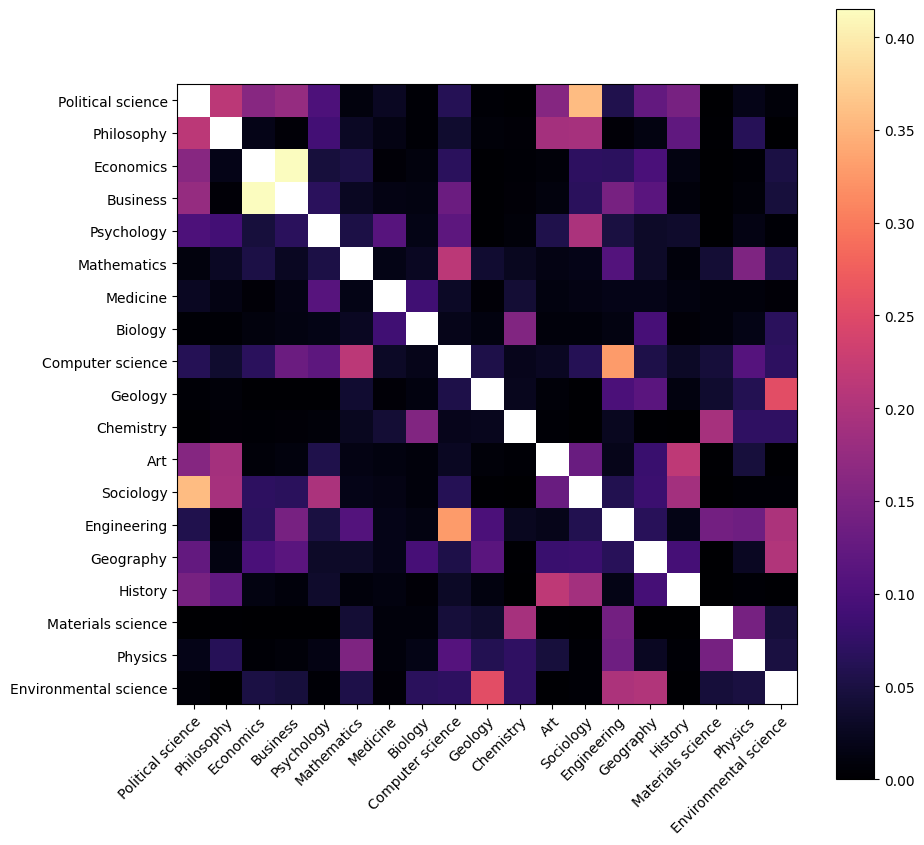

In [51]:
mask = np.ma.masked_where(sim_matrix==1, sim_matrix)

concept_names = list(concept_names_dict.values())

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(mask, cmap='magma')
cbar = ax.figure.colorbar(im, ax=ax)

ax.set_xticks(np.arange(len(concept_names)), labels=concept_names)
ax.set_yticks(np.arange(len(concept_names)), labels=concept_names)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.show()